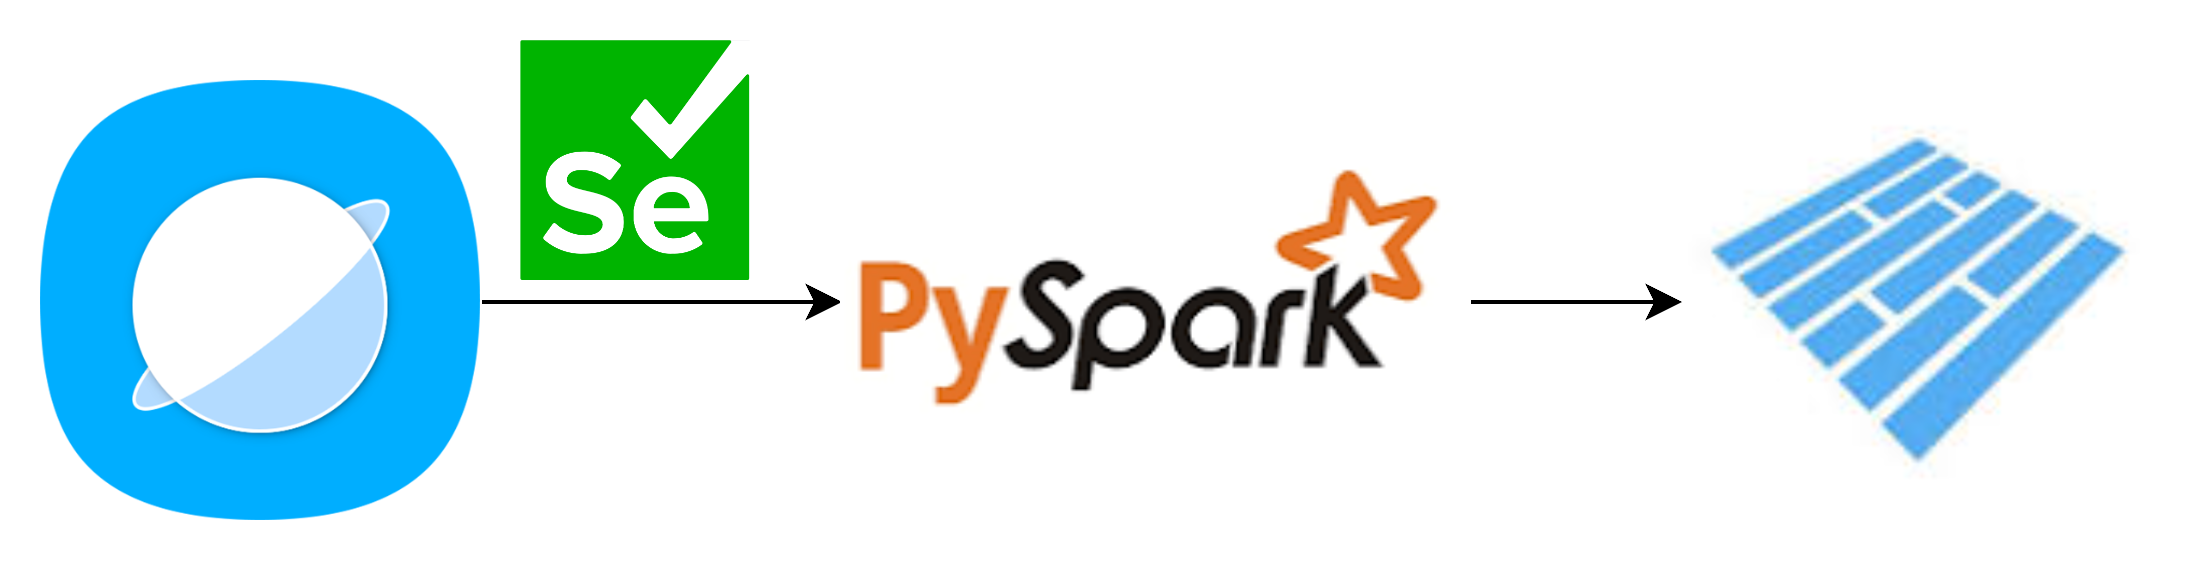

# Import Libraries

In [1]:
from selenium import webdriver
from selenium.webdriver.common.by import By

In [2]:
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.chrome.options import Options
website = 'https://www.adamchoi.co.uk/overs/detailed'
chrome_options = Options()
chrome_service = Service("chromedriver")
driver = webdriver.Chrome(options=chrome_options, service=chrome_service)

# Arsenal Match Performance in 2022/2023

In [3]:
driver.get(website)

In [4]:
al_matches_button = driver.find_element('xpath','//label[@analytics-event="All matches"]')

In [5]:
al_matches_button.click()

In [6]:
matches = driver.find_elements(By.TAG_NAME,'tr')

## Scrap value

In [7]:
date = []
home_team = []
score = []
away_team = []


In [8]:
for match in matches:
    date.append(match.find_element('xpath','./td[1]').text)
    home_team.append(match.find_element('xpath','./td[2]').text)
    score.append(match.find_element('xpath','./td[3]').text)
    away_team.append(match.find_element('xpath','./td[4]').text)

## Convert to Dataframe

In [10]:
from pyspark import SparkConf, SparkContext

In [9]:
import pyspark
from pyspark.sql import SparkSession
from pyspark.sql.types import StructType, StructField, StringType

In [11]:
import os
import sys

os.environ['PYSPARK_PYTHON'] = sys.executable
os.environ['PYSPARK_DRIVER_PYTHON'] = sys.executable

In [12]:
spark = SparkSession.builder.appName('ProjectSparkWebScrap').getOrCreate()

In [47]:
schema = StructType([
    StructField('date', StringType(), True),
    StructField('home_team', StringType(), True),
    StructField('score', StringType(), True),
    StructField('away_team', StringType(), True)
])

# Create a list of rows to be converted to a Spark DataFrame
data = list(zip(date, home_team, score, away_team))

# Create a Spark DataFrame from the list of rows and the schema
spark_df = spark.createDataFrame(data, schema)

In [48]:
arsenal = spark_df.filter((spark_df['home_team']=='Arsenal')|(spark_df['away_team']=='Arsenal'))

In [49]:
arsenal.printSchema()

root
 |-- date: string (nullable = true)
 |-- home_team: string (nullable = true)
 |-- score: string (nullable = true)
 |-- away_team: string (nullable = true)



In [50]:
arsenal = arsenal.select(to_date(arsenal['date'],'dd-MM-yyyy').alias('date'),arsenal['home_team'],arsenal['score'],arsenal['away_team'])

In [53]:
# first date in 2022/2023
arsenal.agg({'date':'min'}).show()

+----------+
| min(date)|
+----------+
|2022-08-05|
+----------+



In [54]:
# first date in 2022/2023
arsenal.agg({'date':'max'}).show()

+----------+
| max(date)|
+----------+
|2023-05-28|
+----------+



In [51]:
arsenal.show()

+----------+--------------+-----+-------------+
|      date|     home_team|score|    away_team|
+----------+--------------+-----+-------------+
|2022-08-05|Crystal Palace|0 - 2|      Arsenal|
|2022-08-13|       Arsenal|4 - 2|    Leicester|
|2022-08-20|   Bournemouth|0 - 3|      Arsenal|
|2022-08-27|       Arsenal|2 - 1|       Fulham|
|2022-08-31|       Arsenal|2 - 1|  Aston Villa|
|2022-09-04|    Man United|3 - 1|      Arsenal|
|2022-09-18|     Brentford|0 - 3|      Arsenal|
|2022-10-01|       Arsenal|3 - 1|    Tottenham|
|2022-10-09|       Arsenal|3 - 2|    Liverpool|
|2022-10-16|         Leeds|0 - 1|      Arsenal|
|2022-10-23|   Southampton|1 - 1|      Arsenal|
|2022-10-30|       Arsenal|5 - 0|Nott'm Forest|
|2022-11-06|       Chelsea|0 - 1|      Arsenal|
|2022-11-12|        Wolves|0 - 2|      Arsenal|
|2022-12-26|       Arsenal|3 - 1|     West Ham|
|2022-12-31|      Brighton|2 - 4|      Arsenal|
|2023-01-03|       Arsenal|0 - 0|    Newcastle|
|2023-01-15|     Tottenham|0 - 2|      A

In [55]:
arsenal.write.mode('overwrite').parquet('arsenal_score.parquet')

# Barcelona Match Performance from 17/18 to 2022/2023

In [56]:
from selenium.webdriver.support.ui import Select
import time

In [57]:
website = 'https://www.adamchoi.co.uk/overs/detailed'
chrome_options = Options()
chrome_service = Service("chromedriver")
driver = webdriver.Chrome(options=chrome_options, service=chrome_service)

In [58]:
driver.get(website)

In [59]:
al_matches_button = driver.find_element('xpath','//label[@analytics-event="All matches"]')

In [60]:
al_matches_button.click()

In [61]:
dropdown = Select(driver.find_element(By.ID,'country'))
dropdown.select_by_visible_text('Spain')
time.sleep(3)

In [89]:
season = []
for i in range(1,7):
    season.append(driver.find_element('xpath',f'//*[@id="season"]/option[{i}]').text)

In [94]:
season = []
i = 1

while True:
    try:
        option = driver.find_element('xpath', f'//*[@id="season"]/option[{i}]')
        season.append(option.text)
        i += 1
    except Exception as e:
        print("maximum season", max(season))
        break

maximum season 22/23


In [95]:
season

['22/23', '21/22', '20/21', '19/20', '18/19', '17/18']

In [98]:
date = []
home_team = []
score = []
away_team = []
for i in (season):
    dropdown = Select(driver.find_element(By.ID,'season'))
    dropdown.select_by_visible_text(i)
    time.sleep(3)
    matches = driver.find_elements(By.TAG_NAME,'tr')
    for match in matches:
        date.append(match.find_element('xpath','./td[1]').text)
        home_team.append(match.find_element('xpath','./td[2]').text)
        score.append(match.find_element('xpath','./td[3]').text)
        away_team.append(match.find_element('xpath','./td[4]').text)

In [99]:
schema = StructType([
    StructField('date', StringType(), True),
    StructField('home_team', StringType(), True),
    StructField('score', StringType(), True),
    StructField('away_team', StringType(), True)
])

# Create a list of rows to be converted to a Spark DataFrame
data = list(zip(date, home_team, score, away_team))

# Create a Spark DataFrame from the list of rows and the schema
spark_df = spark.createDataFrame(data, schema)

In [102]:
barcelona = spark_df.filter((spark_df['home_team']=='Barcelona')|(spark_df['away_team']=='Barcelona'))

In [107]:
barcelona = barcelona.select(to_date(barcelona['date'],'dd-MM-yyyy').alias('date'),barcelona['home_team'],barcelona['score'],barcelona['away_team'])

In [108]:
# first date of the data
barcelona.agg({'date':'min'}).show()

+----------+
| min(date)|
+----------+
|2017-08-20|
+----------+



In [109]:
# last date of the data
# first date of the data
barcelona.agg({'date':'max'}).show()

+----------+
| max(date)|
+----------+
|2023-06-04|
+----------+



In [113]:
barcelona.write.mode('overwrite')\
.partitionBy('date')\
.parquet('barcelona_score.parquet')